# Deshift on the WILDS Amazon Reviews Dataset

In this notebook, we fine-tune a LLaMA model for sequence classification on the [WILDS Amazon Reviews](https://wilds.stanford.edu/datasets/#amazon) dataset. In this task, the input is a product review written in text, and the label is a number-of-stars from 1 to 5. Importantly, the individuals who write the reviews are known to be disjoint between the train, validation, and test splits of the dataset. As a result, there is a distribution shift.

For the LlaMA base model, we use the 58M-parameter [BabyLlaMA](https://huggingface.co/timinar/baby-llama-58m) submission for the BabyLM benchmark. We train two models:
- **Empirical Risk Minimization (ERM):** This model is trained by combining all elements in a batch using a flat average.
- **Superquantile:** This model is trained using the superquantile/CVaR objective with a head probability of `0.5`. In other words, the top 50% highest losses within each batch are used for backpropagation.

In [1]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm import tqdm
import datetime
import time
import random
import os
import sys
import json

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForCausalLM, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset

import sys
sys.path.append("..")
from deshift import make_spectral_risk_measure, make_superquantile_spectrum

In [2]:
ROOT_DIR = "/mnt/ssd/ronak/datasets/wilds"
CACHE_DIR = "/mnt/ssd/ronak/models"
SAVE_DIR = "/mnt/hdd/ronak/wilds/amazon"
OUT_DIR = "/mnt/ssd/ronak/output/wilds/amazon"
MODEL_NAME = "llama"

## Build Dataset

We tokenize the dataset, which contains about 250,000 reviews in the training set a priori. The goal is to get a sense of the sequence lengths when using the LlaMA tokenizer. Because they are quite long (median `~128`), we subset the dataset to the shorter reviews. The sequence length has a large impact on the eventual memory consumption of the trained model.

In [3]:
DATA_SIZE = 5000
SEQ_LEN = 80

In [4]:
tokenizer = AutoTokenizer.from_pretrained("timinar/baby-llama-58m", cache_dir=CACHE_DIR)

In [5]:
# Load the full dataset, and download it if necessary
dataset = get_dataset(dataset="amazon", download=True, root_dir=ROOT_DIR)

In [6]:
def get_lens(split, n, tokenizer):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    lens = []

    loader = get_train_loader("standard", dataset.get_subset(split), batch_size=1)
    print(f"Loader size: {len(loader)}.")
    for i, (x, y, z) in tqdm(enumerate(loader)):
        encoded_dict = tokenizer(
            x[0], 
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            return_tensors="pt", 
        )

        # Add the encoded sentence to the list.
        lens.append(encoded_dict["input_ids"].shape[1])

        if i == n - 1:
            break

    return np.array(lens)


# generate encoded tokens:
def get_split(split, tokenizer, max_length=80, idx=None):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attn_masks = []
    labels = []
    metadata = []

    # For every sentence...
    # sentences = dataset[split]["text"]
    # train_data = dataset.get_subset(split)
    loader = get_train_loader("standard", dataset.get_subset(split), batch_size=1)
    print(f"Loader size: {len(loader)}.")
    for i, (x, y, z) in tqdm(enumerate(loader)):
        if idx is None or i in idx:
            encoded_dict = tokenizer(
                x[0], 
                add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                max_length=max_length,
                truncation=True,
                padding='max_length',
                return_tensors="pt",  # Return pytorch tensors.return_tensors='pt'
                return_attention_mask=True,
            )

            # Add the encoded sentence to the list.
            input_ids.append(encoded_dict["input_ids"])
            attn_masks.append(encoded_dict["attention_mask"])
            labels.append(y.item())
            metadata.append(z)

    input_ids = torch.cat(input_ids, dim=0)
    attn_masks = torch.cat(attn_masks, dim=0)
    labels = torch.tensor(labels).long()
    metadata = torch.cat(metadata)

    return input_ids, attn_masks, labels, metadata

In [7]:
n = 3000
seq_len = get_lens("train", n, tokenizer)

Loader size: 245502.


0it [00:00, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (136 > 128). Running this sequence through the model will result in indexing errors
2999it [00:01, 1508.22it/s]


0.5 quantile: 124.0
0.75 quantile: 245.0
0.9 quantile: 383.0999999999999


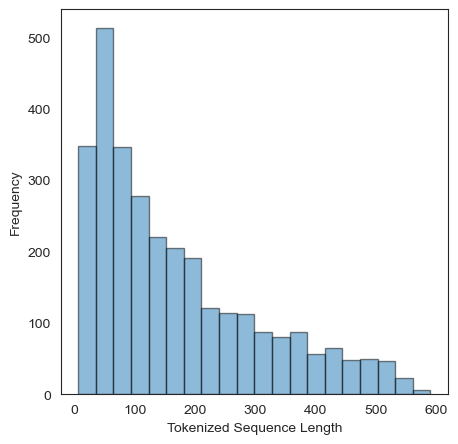

In [8]:
for q in [0.5, 0.75, 0.9]:
    print(f"{q} quantile: {np.quantile(seq_len, q)}")

sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(seq_len, bins=20, color="tab:blue", alpha=0.5, edgecolor="k")
ax.set_xlabel("Tokenized Sequence Length")
ax.set_ylabel("Frequency")
plt.show()

In [9]:
# loader sizes
sample_sizes = {}
for split in ["train", "val", "test"]:
    loader = get_train_loader("standard", dataset.get_subset(split), batch_size=1)
    print(f"{split} loader size: {len(loader)}.")
    sample_sizes[split] = len(loader)

train loader size: 245502.
val loader size: 100050.
test loader size: 100050.


In [10]:
np.random.seed(123)

for split in ["train", "val", "test"]:
    idx = np.random.choice(sample_sizes[split], DATA_SIZE, replace=False)
    input_ids, attn_masks, labels, metadata = get_split(split, tokenizer, max_length=80, idx=idx)
    
    print(input_ids.shape)
    torch.save(input_ids, os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_input_ids.pt"))
    torch.save(attn_masks, os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_attn_masks.pt"))
    torch.save(labels, os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_labels.pt"))
    torch.save(metadata, os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_metadata.pt"))

Loader size: 245502.


0it [00:00, ?it/s]

245502it [00:22, 10728.64it/s]


torch.Size([5000, 80])
Loader size: 100050.


100050it [00:13, 7239.12it/s]


torch.Size([5000, 80])
Loader size: 100050.


100050it [00:13, 7511.15it/s]

torch.Size([5000, 80])


## Train Model

We can begin the training procedure. This involves:
- Setting up the superquantile objective, which is only a few extra lines of code.
- Setting up the model, which requires a little bit of surgery with the current HuggingFace API. For computational reasons, we only train the last transformer layer (of 16) and the additional "head" portion of the model.

In [11]:
LEARNING_RATE = 6e-5
ADAMW_TOLERANCE = 1e-8
BATCH_SIZE = 32
EPOCHS = 2
SEED = 123
OBJECTIVE = "erm"
DEVICE = 0

In [12]:
def load_data(split):
    input_ids  = torch.load(os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_input_ids.pt"))
    attn_masks = torch.load(os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_attn_masks.pt"))
    labels     = torch.load(os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_labels.pt"))
    metadata   = torch.load(os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_metadata.pt"))
    return input_ids, attn_masks, labels, metadata

class MaskedSequenceClassificationDataset(Dataset):
    def __init__(self, input_ids, attn_masks, labels, metadata):
        self.input_ids = input_ids
        self.attn_masks = attn_masks
        self.labels = labels
        self.metadata = metadata

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i):
        return self.input_ids[i], self.attn_masks[i], self.labels[i], self.metadata[i]

In [13]:
input_ids, attn_masks, labels, metadata = load_data("train")
train_dataset = MaskedSequenceClassificationDataset(input_ids, attn_masks, labels, metadata)
train_dataloader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} training samples.".format(len(train_dataset)))

input_ids, attn_masks, labels, metadata = load_data("val")
val_dataset = MaskedSequenceClassificationDataset(input_ids, attn_masks, labels, metadata)
validation_dataloader = DataLoader(
    val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} validation samples.".format(len(val_dataset)))

input_ids, attn_masks, labels, metadata = load_data("test")
test_dataset = MaskedSequenceClassificationDataset(input_ids, attn_masks, labels, metadata)
test_dataloader = DataLoader(
    test_dataset, sampler=RandomSampler(test_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} test samples.".format(len(test_dataset)))

5,000 training samples.
5,000 validation samples.
5,000 test samples.


In [14]:
print(np.bincount(train_dataset.labels.numpy()) / len(train_dataset))
print(np.bincount(val_dataset.labels.numpy()) / len(val_dataset))

[0.0096 0.026  0.0948 0.3036 0.566 ]
[0.0126 0.0302 0.0924 0.276  0.5888]


In [15]:
## model

model = AutoModelForCausalLM.from_pretrained(
    "timinar/baby-llama-58m",
    output_attentions=False,
    output_hidden_states=False,
    cache_dir=CACHE_DIR,
).to(DEVICE)

# n_labels = 5
# model = AutoModelForSequenceClassification.from_pretrained("timinar/baby-llama-58m", cache_dir=CACHE_DIR)
# model surgery
# model.score = nn.Linear(in_features=512, out_features=n_labels, bias=False)
# model.num_labels = n_labels

# for param in model.parameters():
#     param.requires_grad = False
# for module in model.model.layers[-UNFROZEN:] + [model.model.norm, model.score]:
#     for param in module.parameters():
#         param.requires_grad = True

We also note that the classes are quite imbalanced in this dataset. We make the conscious choice to keep them this way and see if the risk-sensitive model can control error in the less frequent classes.

In [16]:
print(np.bincount(train_dataset.labels.numpy()) / len(train_dataset))
print(np.bincount(val_dataset.labels.numpy()) / len(val_dataset))

[0.0096 0.026  0.0948 0.3036 0.566 ]
[0.0126 0.0302 0.0924 0.276  0.5888]


In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, eps = ADAMW_TOLERANCE)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = EPOCHS * BATCH_SIZE * len(train_dataloader))

In [18]:
def to_dict_of_lists(lst):
    return {key: [i[key] for i in lst] for key in lst[0]}

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
# Seed everything.
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

training_stats = []
total_t0 = time.time()
for epoch_i in range(EPOCHS):

    # ========================================
    #               Training
    # ========================================

    print("")
    print("======== Epoch {:} / {:} ========".format(epoch_i + 1, EPOCHS))
    print("Training...")

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(
                "  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.   Loss: {:0.5f}".format(
                    step, len(train_dataloader), elapsed, total_train_loss / step
                )
            )

        b_input_ids = batch[0].to(DEVICE)
        b_input_mask = batch[1].to(DEVICE)
        b_labels = batch[2].to(DEVICE)

        model.zero_grad()

        output = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            labels=b_input_ids,
            return_dict=True,
        )

        loss = output.loss
        # logits = output.logits

        # one line of code addition!
        # losses = F.cross_entropy(logits, b_labels, reduction="none")
        # weights = compute_sample_weight(losses)
        # loss = weights @ losses

        total_train_loss += loss.item()
        loss.backward()
        

        # TODO: See if this is needed.
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        # total_train_accuracy += flat_accuracy(logits.detach().cpu().numpy(), b_labels.detach().cpu().numpy())

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    # print("  Average training accuracy: {0:.3f}".format(avg_train_accuracy))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(DEVICE)
        b_input_mask = batch[1].to(DEVICE)
        b_labels = batch[2].to(DEVICE)

        with torch.no_grad():
            output = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                labels=b_input_ids,
            )
            loss = output.loss
            logits = output.logits

        total_eval_loss += loss.item()

        # logits = logits.detach().cpu().numpy()
        # label_ids = b_labels.to("cpu").numpy()

        # total_eval_accuracy += flat_accuracy(logits, label_ids)

    # avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    # print("  Validation Accuracy: {0:.3f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.3f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            "epoch": epoch_i + 1,
            "Training Loss": avg_train_loss,
            # "Training Accur.": avg_train_accuracy,
            "Valid. Loss": avg_val_loss,
            # "Valid. Accur.": avg_val_accuracy,
            "Training Time": training_time,
            "Validation Time": validation_time,
        }
    )

print("")
print("Training complete!")

print(
    "Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0))
)

# Save the model.
torch.save(model.state_dict(), os.path.join(OUT_DIR, f"{MODEL_NAME}_{OBJECTIVE}.pt"))
training_stats = to_dict_of_lists(training_stats)
with open(os.path.join(OUT_DIR, f"{MODEL_NAME}_{OBJECTIVE}.json"), "w") as f:
    json.dump(training_stats, f, indent=2)


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    157.    Elapsed: 0:00:05.   Loss: 3.39548
  Batch    80  of    157.    Elapsed: 0:00:10.   Loss: 3.36823
  Batch   120  of    157.    Elapsed: 0:00:14.   Loss: 3.36275

  Average training loss: 3.346
  Training epoch took: 0:00:19

Running Validation...
  Validation Loss: 3.462
  Validation took: 0:00:06

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    157.    Elapsed: 0:00:05.   Loss: 3.08475
  Batch    80  of    157.    Elapsed: 0:00:10.   Loss: 3.10151
  Batch   120  of    157.    Elapsed: 0:00:15.   Loss: 3.10533

  Average training loss: 3.108
  Training epoch took: 0:00:19

Running Validation...
  Validation Loss: 3.456
  Validation took: 0:00:06

Training complete!
Total training took 0:00:50 (h:mm:ss)


## Understanding Performance

We inspect the test performance of the two models, which were trained with identical parameters, except one used the `0.5`-superquantile. We can compare models across a few axes:
- **Classes**: Given the class imbalance, we can look at per class precision and recall.
- **Metadata Groups**: Subpopulations are given in the dataset from the groupings.
As an initial pass, we also look at accuracy as the test set is drawn from a different distribution.

In [17]:
%%capture

erm = torch.load(os.path.join(OUT_DIR, f"erm.pt"))
erm.eval()

superquantile = torch.load(os.path.join(OUT_DIR, f"superquantile.pt"))
superquantile.eval()

In [18]:
# small enough to fit in CPU memory
test_dataset = load_dataset("test")
test_dataloader = DataLoader(
    test_dataset, sampler=RandomSampler(test_dataset), batch_size=BATCH_SIZE
)

In [19]:
def get_scores(model):
    logit_list = []
    label_list = []
    meta_list = []
    for batch in tqdm(test_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_metadata = batch[3]

        with torch.no_grad():
            output = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = output.loss
            logits = output.logits


        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        logit_list.append(logits)
        label_list.append(label_ids)
        meta_list.append(b_metadata.numpy())

    scores = np.concatenate(logit_list, axis=0)
    y_true = np.concatenate(label_list)
    metadata = np.concatenate(meta_list, axis=0)

    return y_true, scores, metadata
    


The ERM accuracy is given below.

In [26]:
y_true_erm, scores_erm, meta_list_erm = get_scores(erm)
flat_accuracy(scores_erm, y_true_erm)

100%|██████████| 306/306 [00:36<00:00,  8.45it/s]


0.661597832754038

The superquantile accuracy is given below.

In [27]:
y_true_sq, scores_sq, meta_list_sq = get_scores(superquantile)
flat_accuracy(scores_sq, y_true_sq)

100%|██████████| 306/306 [00:38<00:00,  7.99it/s]


0.6771876916785934

Note though, that this is not far from the chance level, which is about `0.61`.

In [25]:
np.bincount(y_true_sq) / len(y_true_sq)

array([0.0155643 , 0.02655387, 0.08344408, 0.25562257, 0.61881517])

We look at the full classification report to compare the methods.

In [28]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(y_true_erm, np.argmax(scores_erm, axis=1)))

              precision    recall  f1-score   support

           0       0.33      0.32      0.33       609
           1       0.32      0.27      0.30      1039
           2       0.42      0.43      0.42      3265
           3       0.46      0.41      0.44     10002
           4       0.78      0.82      0.80     24213

    accuracy                           0.66     39128
   macro avg       0.46      0.45      0.46     39128
weighted avg       0.65      0.66      0.66     39128



In [31]:
print(classification_report(y_true_sq, np.argmax(scores_sq, axis=1)))

              precision    recall  f1-score   support

           0       0.40      0.15      0.22       609
           1       0.34      0.39      0.36      1039
           2       0.43      0.41      0.42      3265
           3       0.52      0.23      0.32     10002
           4       0.74      0.92      0.82     24213

    accuracy                           0.68     39128
   macro avg       0.49      0.42      0.43     39128
weighted avg       0.64      0.68      0.64     39128



There are notable increases in the precision of the superquantile model across the uncommon classes, which account for less than 10% of the data.